In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from scipy import stats
from sklearn import metrics

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')


In [4]:
# Check if GPU is available
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Please install GPU version of TF


In [6]:
# Download dataset
! wget https://www.utwente.nl/en/eemcs/ps/dataset-folder/sensors-activity-recognition-dataset-shoaib.rar -P ../data/

# Extract dataset using unrar
!pip install unrar
!unrar e ../data/sensors-activity-recognition-dataset-shoaib.rar ../data/

--2020-12-01 17:38:59--  https://www.utwente.nl/en/eemcs/ps/dataset-folder/sensors-activity-recognition-dataset-shoaib.rar
Resolving www.utwente.nl (www.utwente.nl)... 130.89.3.249, 2001:67c:2564:a102::1:1
Connecting to www.utwente.nl (www.utwente.nl)|130.89.3.249|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 100080442 (95M) [application/x-rar-compressed]
Saving to: ‘../data/sensors-activity-recognition-dataset-shoaib.rar’

sensors-activity-re 100%[===================>]  95.44M  24.6MB/s    in 4.1s    

2020-12-01 17:39:04 (23.5 MB/s) - ‘../data/sensors-activity-recognition-dataset-shoaib.rar’ saved [100080442/100080442]


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from ../data/sensors-activity-recognition-dataset-shoaib.rar

Extracting  ../data/Participant_1.csv                                      0%  1%  2%  3%  4%  5%  6%  7%  8%  9% 10%  OK 
Extracting  ../data/Particip

In [7]:
df = pd.DataFrame()
for i in range(10):
    df_tmp = pd.read_csv('../data/Participant_' + str(i+1) + '.csv', header=1)
    df = pd.concat([df, df_tmp])

# View top 5 rows of dataframe
df.head()

,time_stamp,Ax,Ay,Az,Lx,Ly,Lz,Gx,Gy,Gz,Mx,My,Mz,Unnamed: 13,time_stamp.1,Ax.1,Ay.1,Az.1,Lx.1,Ly.1,Lz.1,Gx.1,Gy.1,Gz.1,Mx.1,My.1,Mz.1,Unnamed: 27,time_stamp.2,Ax.2,Ay.2,Az.2,Lx.2,Ly.2,Lz.2,Gx.2,Gy.2,Gz.2,Mx.2,My.2,Mz.2,Unnamed: 41,time_stamp.3,Ax.3,Ay.3,Az.3,Lx.3,Ly.3,Lz.3,Gx.3,Gy.3,Gz.3,Mx.3,My.3,Mz.3,Unnamed: 55,time_stamp.4,Ax.4,Ay.4,Az.4,Lx.4,Ly.4,Lz.4,Gx.4,Gy.4,Gz.4,Mx.4,My.4,Mz.4,Unnamed: 69
0,1.390000e+12,-1.81150,-14.873,-1.34840,-1.26910,-5.1057,-0.66445,-0.53206,-3.18690,0.23976,12.72,40.74,-6.00,NaN,1.390000e+12,-1.19860,-13.852,3.7865,-1.76980,-4.0625,3.89850,-3.6255,1.07390,0.13622,18.84,55.92,-6.72,NaN,1.390000e+12,0.17706,-10.569,1.8251,-7.5051,-4.7736,-0.062476,-0.36652,1.27060,-0.52412,-30.30,31.08,3.96,NaN,1.390000e+12,2.79220,-12.5720,-4.3177,-0.098712,-3.385700,-2.46480,0.021075,1.02990,1.22690,-18.72,31.74,17.82,NaN,1.390000e+12,4.3177,-2.36990,-0.43585,-5.3574,-0.95749,0.318860,0.52565,-0.18815,0.285880,-22.20,6.48,4.56,walking
1,1.390000e+12,0.24517,-14.070,-0.84446,0.70147,-4.2969,-0.17199,-0.25229,-1.79660,0.40745,12.54,40.74,-6.78,NaN,1.390000e+12,-2.38360,-16.590,2.9965,-2.70250,-6.7890,2.86820,-3.4899,0.39034,0.40073,18.60,55.86,-6.06,NaN,1.390000e+12,0.16344,-12.190,2.0703,-7.3573,-6.2618,-0.042442,-0.54459,1.28070,0.34025,-31.02,29.88,3.36,NaN,1.390000e+12,2.38360,-10.9920,-4.6037,-0.404440,-1.774500,-2.74830,0.201890,0.53573,1.32280,-18.84,31.74,17.70,NaN,1.390000e+12,5.1213,-2.19290,-0.70826,-4.5352,-0.67629,0.081656,0.43616,0.16371,0.198230,-21.90,7.14,5.34,walking
2,1.390000e+12,-0.57205,-14.628,-1.75700,-0.21760,-4.8531,-1.05650,-1.04920,0.29138,0.29230,12.42,40.68,-8.10,NaN,1.390000e+12,-4.63090,-16.603,2.0703,-4.34550,-6.8081,1.68890,-3.3851,-1.99200,1.12280,18.72,55.80,-4.26,NaN,1.390000e+12,0.57205,-12.626,2.2474,-6.7655,-6.5138,0.017921,-0.70952,1.15820,0.99724,-31.26,29.22,3.24,NaN,1.390000e+12,1.56630,-9.0848,-4.5764,-1.003600,0.201530,-2.75150,0.287720,0.10049,1.20710,-19.02,31.68,17.52,NaN,1.390000e+12,5.6116,-2.12480,-1.26670,-4.0408,-0.55974,-0.523690,0.32284,0.43127,0.211970,-21.60,7.50,5.64,walking
3,1.390000e+12,-0.69464,-12.939,-3.09180,-0.32273,-3.1786,-2.21970,-2.37200,1.00820,0.34972,12.30,40.74,-8.52,NaN,1.390000e+12,-4.78070,-16.453,1.1577,-4.19540,-6.6731,0.74084,-3.1017,-3.04390,0.79138,18.84,55.62,-3.12,NaN,1.390000e+12,1.21220,-12.476,2.2882,-5.9716,-6.1990,0.016760,-0.78191,1.10200,1.33380,-31.44,28.80,3.24,NaN,1.390000e+12,-0.61292,-8.5263,-2.9284,-2.827100,0.859490,-1.14670,0.175930,-0.21441,0.90469,-18.96,31.86,17.22,NaN,1.390000e+12,6.0611,-1.47100,-2.47890,-3.5908,0.15795,-1.880200,0.20403,0.72846,0.164930,-21.12,8.40,6.12,walking
4,1.390000e+12,0.87170,-12.000,-1.56630,1.13740,-2.2390,-0.65476,-2.79010,0.65485,0.22724,12.24,40.80,-8.88,NaN,1.390000e+12,-0.92618,-12.190,-1.0624,-0.18116,-2.4144,-1.28500,-2.7587,-4.46020,0.69364,19.38,55.44,-0.84,NaN,1.390000e+12,2.24740,-11.387,1.9886,-4.6603,-4.8230,-0.329740,-0.82436,0.90561,2.15600,-31.56,28.32,3.30,NaN,1.390000e+12,-1.18500,-9.3436,-2.2337,-3.209900,0.085583,-0.45569,-0.033292,-0.48625,0.60720,-18.84,32.10,17.04,NaN,1.390000e+12,7.7091,-0.77636,-3.54130,-1.9450,0.85796,-2.995300,0.09896,0.94379,0.064752,-20.94,8.70,6.30,walking


In [10]:
df[df.columns[len(df.columns)-1]].unique()

array(['walking', 'standing', 'jogging', 'sitting', 'biking', 'upstairs',
       'downstairs', 'upsatirs'], dtype=object)

In [20]:
df_x_axis = df[['Ax','Lx','Gx','Mx']]

In [22]:
df_x_axis

,Ax,Lx,Gx,Mx
0,-1.81150,-1.269100,-0.53206,12.72
1,0.24517,0.701470,-0.25229,12.54
2,-0.57205,-0.217600,-1.04920,12.42
3,-0.69464,-0.322730,-2.37200,12.30
4,0.87170,1.137400,-2.79010,12.24
...,...,...,...,...
62995,4.23590,1.959100,-0.60292,-6.96
62996,3.89540,1.599300,-1.83720,-7.14
62997,2.90110,0.544980,-2.46910,-7.86
62998,2.42440,0.029464,-2.82620,-8.16


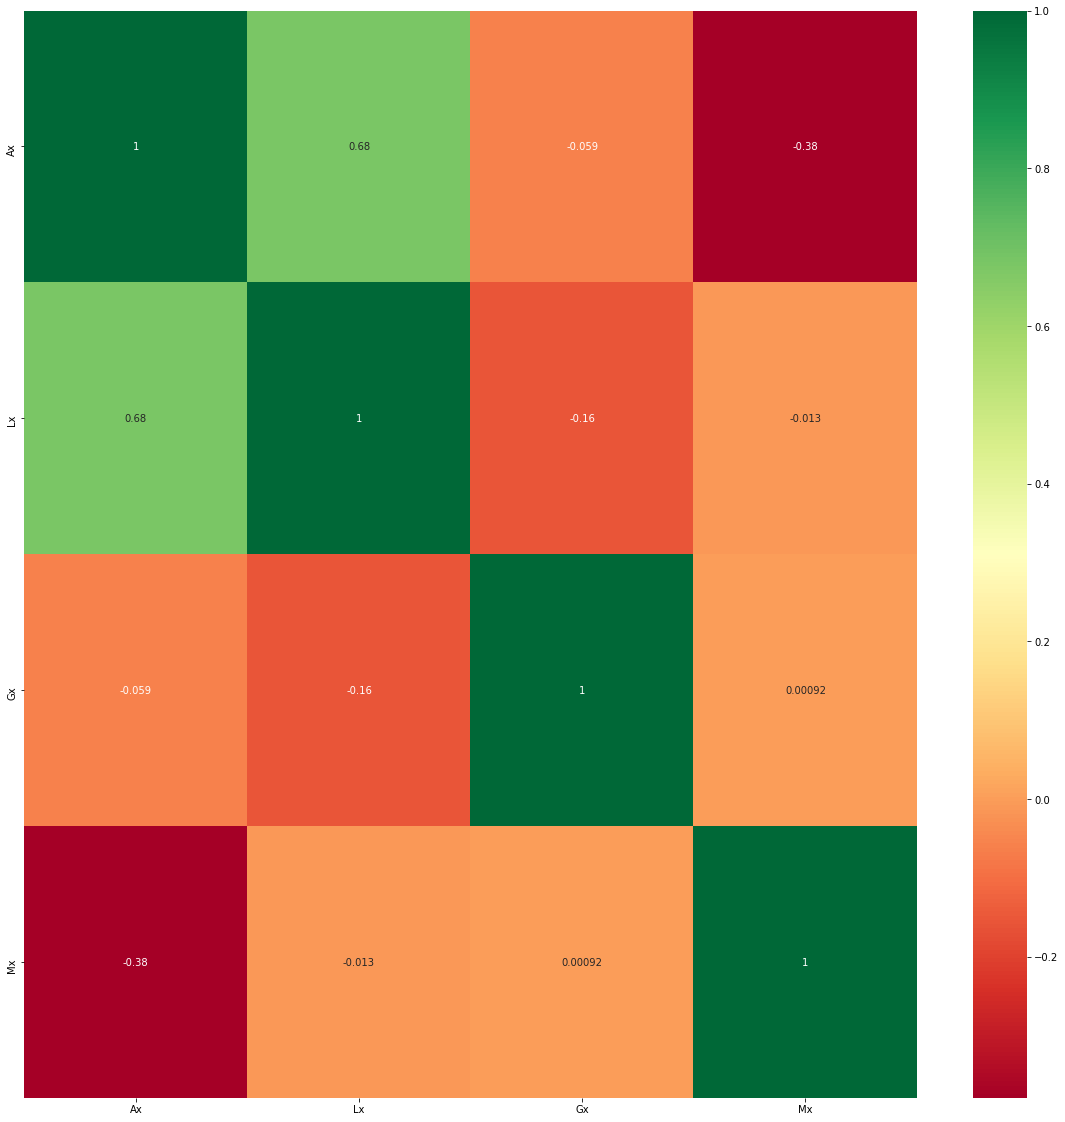

In [21]:
corrmat = df_x_axis.corr()
top_corr_features=corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g = sns.heatmap(df_x_axis[top_corr_features].corr(), annot=True,cmap='RdYlGn')

In [ ]:
df.info()

In [24]:
df.describe()

,time_stamp,Ax,Ay,Az,Lx,Ly,Lz,Gx,Gy,Gz,Mx,My,Mz,Unnamed: 13,time_stamp.1,Ax.1,Ay.1,Az.1,Lx.1,Ly.1,Lz.1,Gx.1,Gy.1,Gz.1,Mx.1,My.1,Mz.1,Unnamed: 27,time_stamp.2,Ax.2,Ay.2,Az.2,Lx.2,Ly.2,Lz.2,Gx.2,Gy.2,Gz.2,Mx.2,My.2,Mz.2,Unnamed: 41,time_stamp.3,Ax.3,Ay.3,Az.3,Lx.3,Ly.3,Lz.3,Gx.3,Gy.3,Gz.3,Mx.3,My.3,Mz.3,Unnamed: 55,time_stamp.4,Ax.4,Ay.4,Az.4,Lx.4,Ly.4,Lz.4,Gx.4,Gy.4,Gz.4,Mx.4,My.4,Mz.4
count,6.300000e+05,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,0.0,6.300000e+05,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,0.0,6.300000e+05,630000.00000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,0.0,6.300000e+05,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,0.0,6.300000e+05,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000
mean,1.390000e+12,0.122884,-7.579559,-2.807124,-0.003061,-0.317290,0.185519,-0.018044,-0.017972,0.022830,-2.162985,24.695768,12.480322,NaN,1.390000e+12,1.190832,-7.597663,-2.813282,0.048338,-0.248393,0.058857,0.000257,0.045111,-0.025036,-6.319876,30.168607,6.811108,NaN,1.390000e+12,4.74549,-6.768818,-2.348493,0.413471,-0.864055,0.159176,-0.026471,0.021960,0.012470,-14.303741,21.051682,10.324533,NaN,1.390000e+12,1.561038,-8.592460,-2.057916,-0.035515,0.033093,0.101860,0.001122,-0.012288,0.010871,-6.592316,34.427760,7.700906,NaN,1.390000e+12,7.230630,-0.895497,-1.009112,0.030635,0.025624,0.032854,0.021933,0.005916,0.016573,-24.249241,4.462356,6.862067
std,0.000000e+00,3.775908,5.684442,4.587958,2.720073,4.219639,3.105666,1.623147,1.456254,0.756521,21.841140,19.559994,18.953307,NaN,0.000000e+00,4.142713,5.478591,4.198057,2.926713,4.080694,2.895513,1.405593,1.254264,0.961677,21.481921,19.561070,20.642661,NaN,0.000000e+00,4.24340,5.160875,3.718551,4.339708,3.926136,2.635841,0.967513,0.985038,1.385462,20.509353,20.136361,22.677330,NaN,0.000000e+00,3.820308,3.659136,2.417609,2.475000,3.562783,1.866068,0.496952,1.122924,0.885703,20.681454,8.904011,15.672863,NaN,0.000000e+00,6.546681,3.018312,3.215342,3.659390,1.768752,1.805900,0.931477,0.940449,0.425748,58.046088,36.094230,51.834489
min,1.390000e+12,-19.477000,-19.668000,-19.409000,-24.473000,-21.387000,-26.779000,-9.221300,-9.998600,-9.461400,-81.780000,-31.200000,-58.500000,NaN,1.390000e+12,-19.300000,-19.600000,-19.491000,-22.918000,-16.452000,-27.444000,-7.747900,-9.944300,-7.596400,-89.940000,-39.840000,-59.040000,NaN,1.390000e+12,-19.47700,-19.600000,-19.041000,-23.789000,-29.287000,-20.239000,-7.280000,-9.963500,-7.791000,-116.880000,-86.220000,-136.500000,NaN,1.390000e+12,-19.518000,-19.600000,-19.395000,-28.576000,-21.138000,-22.537000,-4.368600,-9.899700,-6.559800,-70.020000,-16.020000,-41.640000,NaN,1.390000e+12,-19.600000,-19.368000,-16.658000,-25.645000,-18.511000,-23.580000,-8.808700,-9.967200,-4.911400,-300.480000,-82.680000,-108.300000
25%,1.390000e+12,-1.416500,-10.447000,-6.633100,-0.795360,-1.554300,-0.611853,-0.696690,-0.546110,-0.265730,-17.460000,12.660000,-1.500000,NaN,1.390000e+12,-1.471000,-10.283000,-6.129200,-0.718215,-1.418200,-0.639202,-0.511910,-0.320400,-0.351250,-19.860000,22.680000,-9.900000,NaN,1.390000e+12,2.54700,-9.697700,-4.576400,-1.092225,-2.127800,-0.735670,-0.257480,-0.280390,-0.363460,-27.960000,4.920000,-8.100000,NaN,1.390000e+12,-0.108960,-9.575100,-3.159900,-0.774690,-0.676210,-0.271080,-0.178680,-0.329335,-0.189670,-22.140000,29.160000,-5.880000,NaN,1.390000e+12,6.469700,-2.410800,-3.064600,-0.994882,-0.405230,-0.454675,-0.253510,-0.241900,-0.142940,

In [25]:
split_point = int(len(df) * 0.8)
train_data = df.iloc[:split_point, :]
test_data = df.iloc[split_point:, :]

print("Number of train spamples: ", len(train_data))
print("Number of test spamples: ", len(test_data))

Number of train spamples:  504000
Number of test spamples:  126000


In [26]:
def concat(data):
    
    # Select left pocket data
    left_pocket = data.iloc[:,1:10]
    
    #Square root of sum of squares of accelerometer, linear acceleration and gyroscope data
    left_pocket["MA"] = np.sqrt(np.square(left_pocket['Ax']) + np.square(left_pocket['Ay']) + np.square(left_pocket['Az']))
    left_pocket["ML"] = np.sqrt(np.square(left_pocket['Lx']) + np.square(left_pocket['Ly']) + np.square(left_pocket['Lz']))
    left_pocket["MG"] = np.sqrt(np.square(left_pocket['Gx']) + np.square(left_pocket['Gy']) + np.square(left_pocket['Gz']))
    

    # Select right pocket data
    right_pocket = data.iloc[:,15:24]
    right_pocket.columns=['Ax', 'Ay', 'Az', 'Lx', 'Ly', 'Lz', 'Gx', 'Gy', 'Gz']
    
    #Square root of sum of squares of accelerometer, linear acceleration and gyroscope data
    right_pocket["MA"] = np.sqrt(np.square(right_pocket['Ax']) + np.square(right_pocket['Ay']) + np.square(right_pocket['Az']))
    right_pocket["ML"] = np.sqrt(np.square(right_pocket['Lx']) + np.square(right_pocket['Ly']) + np.square(right_pocket['Lz']))
    right_pocket["MG"] = np.sqrt(np.square(right_pocket['Gx']) + np.square(right_pocket['Gy']) + np.square(right_pocket['Gz']))

    
    # Extract labels 
    labels = data.iloc[:, 69] 
    labels = labels.to_frame()
    labels.columns=['Activity_Label']
    labels = pd.concat([labels]*2, ignore_index=True)
    #replace typo 'upsatirs' with upstairs! 
    labels.loc[(labels['Activity_Label'] == 'upsatirs')] = 'upstairs'
    
    #Concatenate left pocket and right pocket data into a single data frame (we only use left pocket and right pocket data)
    frames = [left_pocket, right_pocket]
    df = pd.concat(frames)
   
    return df, labels

# Generate input data and labels
train_X, train_y = concat(train_data)
test_X, test_y = concat(test_data)

In [ ]:
train_y.head()

In [ ]:
test_y.head()

In [29]:
N_TIME_STEPS = 100 #sliding window length
STEP = 50 #Sliding window step size
N_FEATURES = 12 

def generate_sequence(x, y, n_time_steps, step):
    
    segments = []
    labels = []
    for i in range(0, len(x) - n_time_steps, step):
        ax = x['Ax'].values[i: i + n_time_steps]
        ay = x['Ay'].values[i: i + n_time_steps]
        az = x['Az'].values[i: i + n_time_steps]

        lx = x['Lx'].values[i: i + n_time_steps]
        ly = x['Ly'].values[i: i + n_time_steps]
        lz = x['Lz'].values[i: i + n_time_steps]
        
        gx = x['Gx'].values[i: i + n_time_steps]
        gy = x['Gy'].values[i: i + n_time_steps]
        gz = x['Gz'].values[i: i + n_time_steps]

        MA = x['MA'].values[i: i + n_time_steps]
        ML = x['ML'].values[i: i + n_time_steps]
        MG = x['MG'].values[i: i + n_time_steps]
       
        label = stats.mode(y['Activity_Label'][i: i + n_time_steps])[0][0]
        segments.append([ax, ay, az, lx, ly, lz, gx, gy, gz, MA, ML, MG])
        labels.append(label)
        
    return segments, labels

train_X, train_y = generate_sequence(train_X, train_y, N_TIME_STEPS, STEP)
test_X, test_y = generate_sequence(test_X, test_y, N_TIME_STEPS, STEP)

In [30]:
# reshape input segments and one-hot encode labels
def reshape_segments(x, y, n_time_steps, n_features):
    
    x_reshaped = np.asarray(x, dtype= np.float32).reshape(-1, n_time_steps, n_features)
    y_reshaped = np.asarray(pd.get_dummies(y), dtype = np.float32)
    return x_reshaped, y_reshaped

X_train, y_train = reshape_segments(train_X, train_y, N_TIME_STEPS, N_FEATURES)
X_test, y_test = reshape_segments(test_X, test_y, N_TIME_STEPS, N_FEATURES)

In [47]:
#['Biking' ,' Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking'
print('Biking     - 6')
print('Downstairs - 5')
print('Jogging    - 4')
print('Sitting    - 3')
print('Standing   - 2')
print('Upstairs   - 1')
print('Walking    - 0')

Biking     - 6
Downstairs - 5
Jogging    - 4
Sitting    - 3
Standing   - 2
Upstairs   - 1
Walking    - 0


In [31]:
from keras.regularizers import l2
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Flatten
from keras import optimizers

N_CLASSES = 7
N_HIDDEN_UNITS = 32
L2 = 0.000001

model = Sequential([
    LSTM(N_HIDDEN_UNITS, return_sequences=True, input_shape=(N_TIME_STEPS, N_FEATURES), 
         kernel_initializer='orthogonal', kernel_regularizer=l2(L2), recurrent_regularizer=l2(L2),
         bias_regularizer=l2(L2), name="LSTM_1"),
    Flatten(name='Flatten'),
    Dense(N_HIDDEN_UNITS, activation='relu', kernel_regularizer=l2(L2), bias_regularizer=l2(L2), name="Dense_1"),
    Dense(N_CLASSES, activation='softmax', kernel_regularizer=l2(L2), bias_regularizer=l2(L2), name="Dense_2")
])

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LSTM_1 (LSTM)                (None, 100, 32)           5760      
_________________________________________________________________
Flatten (Flatten)            (None, 3200)              0         
_________________________________________________________________
Dense_1 (Dense)              (None, 32)                102432    
_________________________________________________________________
Dense_2 (Dense)              (None, 7)                 231       
Total params: 108,423
Trainable params: 108,423
Non-trainable params: 0
_________________________________________________________________


In [33]:
opt = optimizers.RMSprop(lr=0.0001)

model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [34]:
BATCH_SIZE = 1024
N_EPOCHS = 30

model.fit(X_train, y_train,
          batch_size=BATCH_SIZE, epochs=N_EPOCHS,
          validation_data=(X_test, y_test))

Epoch 1/30
20/20 [==============================] - 6s 313ms/step - loss: 1.6120 - accuracy: 0.5359 - val_loss: 1.3584 - val_accuracy: 0.6796
Epoch 2/30
20/20 [==============================] - 6s 291ms/step - loss: 1.1307 - accuracy: 0.7924 - val_loss: 1.0111 - val_accuracy: 0.8218
Epoch 3/30
20/20 [==============================] - 6s 292ms/step - loss: 0.8202 - accuracy: 0.8670 - val_loss: 0.7653 - val_accuracy: 0.8900
Epoch 4/30
20/20 [==============================] - 6s 295ms/step - loss: 0.6060 - accuracy: 0.9080 - val_loss: 0.5826 - val_accuracy: 0.9190
Epoch 5/30
20/20 [==============================] - 6s 295ms/step - loss: 0.4577 - accuracy: 0.9289 - val_loss: 0.4535 - val_accuracy: 0.9357
Epoch 6/30
20/20 [==============================] - 6s 306ms/step - loss: 0.3536 - accuracy: 0.9401 - val_loss: 0.3577 - val_accuracy: 0.9482
Epoch 7/30
20/20 [==============================] - 6s 290ms/step - loss: 0.2808 - accuracy: 0.9480 - val_loss: 0.2936 - val_accuracy: 0.9512
Epoch 

Performance Measures 

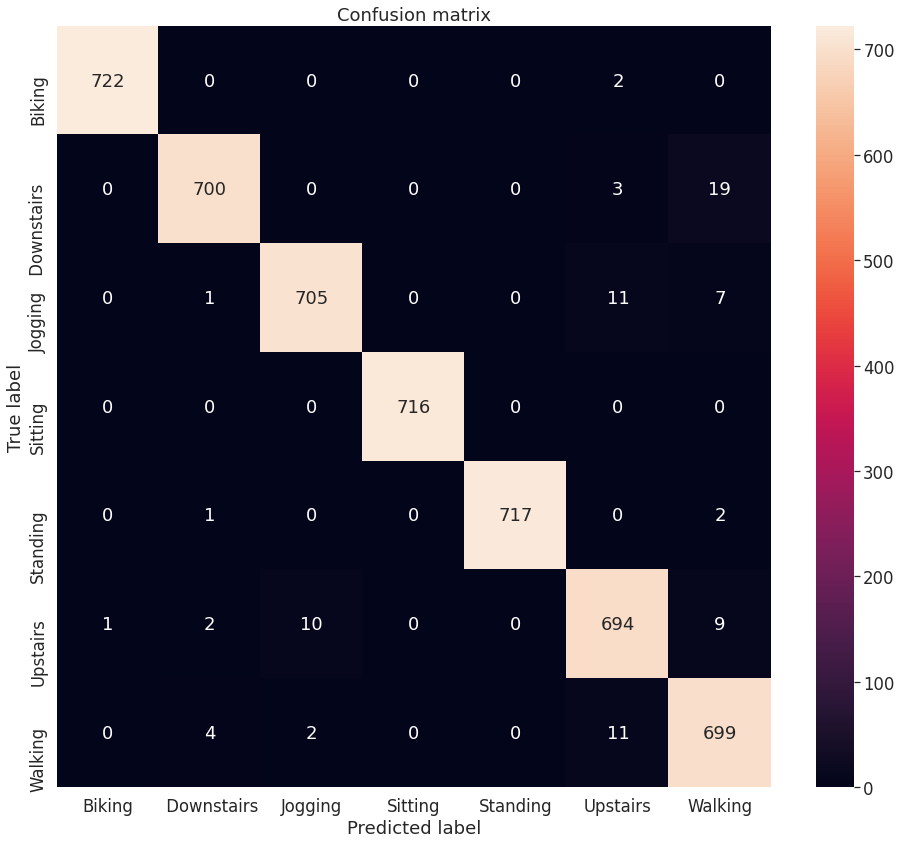

In [35]:
y_pred_ohe = model.predict(X_test)
y_pred_labels = np.argmax(y_pred_ohe, axis=1)
y_true_labels = np.argmax(y_test, axis=1)
confusion_matrix = metrics.confusion_matrix(y_true=y_true_labels, y_pred=y_pred_labels)

LABELS = ['Biking' ,' Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']

plt.figure(figsize=(16, 14))
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show();

In [40]:
print(y_pred_labels)
print()
print(y_true_labels)


[6 6 6 ... 1 1 1]

[6 6 6 ... 1 1 1]


In [52]:
(y_pred_labels-y_true_labels).sum()

105

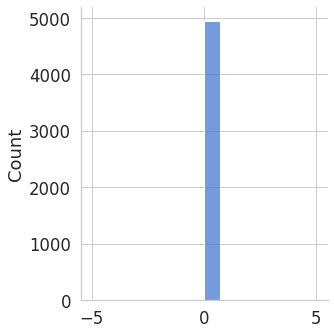

In [59]:
sns.displot(y_true_labels - y_pred_labels)

In [53]:
print('MAE:', metrics.mean_absolute_error(y_true_labels, y_pred_labels))
print('MSE:', metrics.mean_squared_error(y_true_labels, y_pred_labels))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_true_labels, y_pred_labels)))

MAE: 0.054982135768161966
MSE: 0.2185391028185788
RMSE: 0.4674816604088109


In [58]:
mbe = (y_true_labels - y_pred_labels).mean()
print('MBE is:-',mbe)

MBE is:- -0.020841603811036124


In [56]:
print('R2 Score:', metrics.r2_score(y_true_labels ,y_pred_labels))

R2 Score: 0.9453752059888564
